<a href="https://colab.research.google.com/github/ahmedyusef9/deep_learning_course/blob/Assignment01/Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 01
# Image Classification

**Student 1 ID and name,**

**Student 2 ID and name**

### Objective
In this assignment, the goal is to implement a Convolutional Neural Network (CNN) for image classification on the EMNIST Letters dataset. The dataset consists of hand written letters in the English alphabet.


### Instructions

The assignment is arranged in sections, each section includes its instructions with coding tasks, and open ended questions. The provided code offers a starting point, in your tasks you should add code to sections that have the comment `#TODO` at the top. And **never delete** given code.

### Submission Guidelines

*   Assignments are done in pairs, include both ids in the filename when submitting (e.g. *HW01_123456789_123456789.ipynb*) and in the begining of file.
*   Submit only one Jupyter notebook containing your code modifications, comments, and analysis.
*   Include visualizations, graphs, or plots to support your analysis where needed.
*   Provide a conclusion summarizing your findings, challenges faced, and potential future improvements.
*   Notice the approximate runtime for some code sections.


### Important Notes

*  Ensure clarity in code comments and explanations for better understanding.
*  Experiment, analyze, and document your observations throughout the assignment.
*  Feel free to train on GPU (see example in practice 2-3 notebook).
*  It is recommended to explore the datasest and understand it well before implementation.
*  Feel free to seek clarification on any aspect of the assignment in the provided forum in moodle.

In [2]:
# arrange any/all imports here

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.nn as nn

from tqdm import tqdm
import math

# viz and plots
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Section 1: Data Understanding and Preparation

In this section we will load, explore and prepare the dataset for training.

You are given a dataset of grayscale images, each 28x28 pixels, representing handwritten letters (A-Z). The dataset is called* EMNIST Letters* you can read more about it [here](https://www.kaggle.com/datasets/crawford/emnist). The dataset will be downloaded to local enviroment using the `tourchvision`. Your tasks in this section are:

1. Describe how you would preprocess the data for a CNN explain your choice of transofrmation. Implement the preprocessing of your choice in the `transform` code section below.
2. Create train loader for the trian and test sets. Explain your choice of `batch_size`.

In [3]:
#TODO Define transformations for the dataset

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
# Load the EMNIST Letters dataset
# loading the set takes approx 3 mins

train_dataset = torchvision.datasets.EMNIST(
  root='./data',
  split='letters',
  train=True,
  download=True,
  transform=transform
)

test_dataset = torchvision.datasets.EMNIST(
  root='./data',
  split='letters',
  train=False,
  download=True,
  transform=transform
)

# Inspect the dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Shape of one image: {train_dataset[0][0].shape} (C x H x W)")

100%|██████████| 562M/562M [00:32<00:00, 17.3MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Number of training samples: 124800
Number of testing samples: 20800
Shape of one image: torch.Size([1, 28, 28]) (C x H x W)


In [9]:
#TODO Create data loaders for training and testing
import time

num_workers=2
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, num_workers=num_workers)


# start_time = time.time()
# for batch_idx, (data, labels) in enumerate(train_loader):
#     pass  # Simulate data processing
# end_time = time.time()
# print(f"Num Workers: {num_workers}, Time Taken: {end_time - start_time:.2f} seconds")


Num Workers: 2, Time Taken: 39.79 seconds


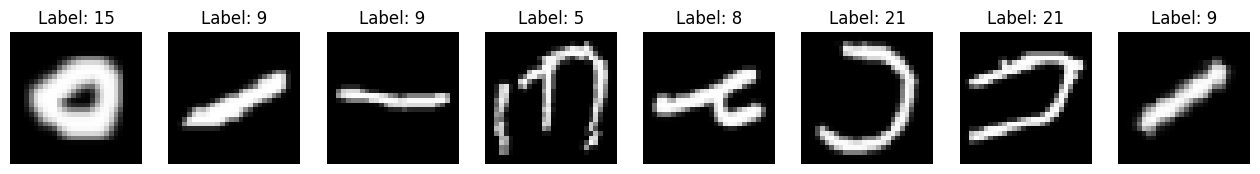

In [10]:
# This code section displays the first 8 images in the batch.

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
  axes[i].imshow(images[i].squeeze(0), cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

## Section 2: CNN Model Design

Design a simple CNN to classify the dataset mentioned above. Your network should include at least two convolutional layers, one pooling layer, and a fully connected layer. The model architicture should be in the following order:

*   Convolutional Layer 1: Implement a convolutional layer with 32 output channels, a 3x3 kernel size, a stride of 1, and a padding of 1.
*   Batch Norm Layer.
*   ReLU Activation Layer.
*   MaxPooling Layer: Add a max-pooling layer with a 2x2 kernel size and a stride of 2.

*   Convolutional Layer 2: Implement a convolutional layer with 64 output channels, a 3x3 kernel size, a stride of 1, and a padding of 1.
*   Batch Norm Layer.
*   ReLU Activation Layer.
*   MaxPooling Layer: like above.

*  Fully Connected Layer 1 (Input Size: Dynamically Inferred Based on Previous Layer Output): Include a fully connected (linear) layer with an input size that is dynamically inferred based on the output size of the previous convolutional layer. Output size 128.

* RelU Activation Function.

*  Fully Connected Layer 2: Add a final fully connected (linear) layer with 26 output features, representing the 26 alphabet letters.


In [13]:
#TODO: Define the CNN architecture
import torch.nn.functional as F

class EMNIST_CNN(nn.Module):
  def __init__(self, num_classes=26):
    super(EMNIST_CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, padding=1, kernel_size=3, stride=1)
    self.norm1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.norm1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

## Section 3: Training and Optimization

In this section we will setup all training parameters and train the model. your tasks in this section are:
1. Create an instance of the model.
2. Choose and explain your choice of optimizer and loss function.
3. Fill the missing code in the training function.
4. Train a model for 5 epochs on the training set (in colab CPU should take ~20 mins).


**Note**: EMNIST labels start from 1 to 26, skipping 0. But our models' results are indexed from 0 to 25.


In [24]:
# optional
# Check if a GPU is available, otherwise use the CPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
#TODO Create an instance of the model
#TODO create an optimizer and loss function
model = EMNIST_CNN()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [26]:
#TODO fill the missing code in the training function

# training function partially implemented for assignment
def train_model(model, loader, optimizer, loss_fun, num_epochs=5):
  model.train() #set model to train
  for epoch in range(num_epochs):

    #create variables to print loss and training accuracy per epoch
    epoch_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
      images, labels = images.to(device), (labels - 1).to(device)  # EMNIST labels are 1-based



      outputs = model(images)

      optimizer.zero_grad()
      loss = loss_function(outputs, labels)

      loss.backward()

      optimizer.step()

      #epoch loss and accuracy for printing
      epoch_loss += loss.item()
      _, predicted = model(images).max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

In [27]:
#TODO train the model.
# training the model for 5 epochs on CPU in colab should take ~20 mins.
# print(images.type())
# print(next(model.parameters()).type())
train_model(model, train_loader, optimizer, loss_function, num_epochs=5)

100%|██████████| 1950/1950 [00:48<00:00, 40.39it/s]

Epoch [5/5], Loss: 0.1828, Accuracy: 97.82%


## Section 4: Evaluate the Model Preformance

The following method evaluates a given model on the loaded test set. Use it to evaluate your trained model on the test set loader. And answer the open-ended questions written below.

In [28]:
# Evaluation function
def evaluate_model(model, loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), (labels - 1).to(device)
      outputs = model(images)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Test Accuracy: {accuracy:.2f}%")

  return accuracy

In [30]:
#TODO evaluate your model
test_accuracy = evaluate_model(model, test_loader)
print(f"Model achieved {test_accuracy:.2f}% accuracy on the test set.")


Test Accuracy: 93.24%
Model achieved 93.24% accuracy on the test set.


Answer the following open ended questions.

1. *If the CNN underperforms, what architectural modifications could improve its performance (e.g., depth, kernel size, activation functions)? Justify your choices.*

2. *How do the choices of batch size, learning rate, and optimizer affect the training process and final performance of your CNN? Provide examples from your results.*

## Section 5: FeedForward Network

In this section you will suggest a feedforward architecture to solve the same problem above, classify the EMNIST images. tasks:


1.   Suggest a feedforward model to solve the same problem the CNN above was trained on. Explain and implement your choice in `EMNIST_FeedForward` class
2.   Train the model on the same dataset - you can reuse the `train_model` method defined above. Explain your choice of loss function and optimizer. (training a 3 layer model takes approx 5 mins on colab CPU)
3.   Evaluate the feedforward model preformance on the test set, again, you can reuse the `evaluate_model` method.




In [ ]:
#TODO Feedforward Model

## Section 6 - Compare & Discuss

In this section we will compare the two approaches.

### 6.1 Comparing Architectures

*After design a feedforward network and a CNN for the same dataset, explain how they differ in terms of:*

*   *Number of parameters*
*   *Ability to capture spatial relationships*
*   *Success/failure in solving the classification task*



### 6.2 Visualize Filters & Feature Maps

Run the following code sections in order to visualize the filters and feature maps of the first layer in your trained CNN. Answer the questions below afterwards.

Notice, you must open the code and specify the name of your CNN model.

In [1]:
#@title Visualizing Kernels from the First Convolutional Layer
#@markdown Open code to edit model name.

cnn_model = cnn_model #ADD YOU MODEL INSTANCE NAME HERE.

# Access the first convolutional layer's filters
filters = cnn_model.layer1[0].weight.data.cpu()  # Shape: (num_filters, input_channels, F, F)

# Number of filters
num_filters = filters.shape[0]

# Calculate grid dimensions for visualization (rows x cols)
grid_cols = 16  # You can adjust this value
grid_rows = math.ceil(num_filters / grid_cols)

# Create a grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, grid_rows * 2))
axes = axes.flatten()  # Flatten for easier indexing

# Plot each filter
for i, ax in enumerate(axes):
    if i < num_filters:
        # Select the first channel of each filter (assuming grayscale)
        filter_ = filters[i, 0, :, :]

        # Normalize filter values to [0, 1]
        filter_ = (filter_ - filter_.min()) / (filter_.max() - filter_.min())

        # Plot the filter
        ax.imshow(filter_.numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    else:
        # Turn off unused axes
        ax.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'cnn_model' is not defined

In [ ]:
#@title Visualizing Feature Maps from the First Convolutional Layer
#@markdown Change the image id and run the code cell to view different images.

#@markdown Open code to edit model name.
image_id = 25  #@param {type: "slider", min: 0, max: 63}
cnn_model = cnn_model #ADD YOU MODEL INSTANCE NAME HERE.
# image_id = 10  #@param {type: "number"}

# Use a trained model
cnn_model.eval()

# Load one image from the dataset (assuming the data is normalized)
image, _ = next(iter(test_loader))  # Assuming test_loader is defined
image = image[image_id].unsqueeze(0).to(device)  # Select an image and add batch dimension

# Pass the image through the first convolutional layer
with torch.no_grad():
    conv1_output = cnn_model.layer1[0](image)  # Assuming 'layer1[0]' is the first conv layer

# Get the number of feature maps
num_feature_maps = conv1_output.shape[1]

# Calculate grid dimensions for visualization
grid_cols = 16  # You can adjust this
grid_rows = math.ceil(num_feature_maps / grid_cols)

# Create a grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, grid_rows * 2))
axes = axes.flatten()

# Plot each feature map
for i, ax in enumerate(axes):
    if i < num_feature_maps:
        # Visualize the ith feature map
        ax.imshow(conv1_output[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Feature {i+1}')
    else:
        # Turn off unused axes
        ax.axis('off')

plt.tight_layout()
plt.show()


**What Are Feature Maps?**

  Each feature map corresponds to the activation of one filter in the convolutional layer.

  Filters detect specific features from the input image.

  The values in a feature map indicate how strongly a specific feature was detected at each spatial location in the input.


**Understanding the Color Map**

  The Viridis color map (default in Matplotlib) uses a gradient of colors:

  *  Purple (low values): Indicates weak or no activation at a particular spatial location. The filter didn't find much of its target feature in this area.
  *  Green (high values): Indicates strong activation. The filter detected its target feature strongly in this region of the input.

Given the visualizations and explanation above, answer the following questions:



---



*1. Are there any filters that have almost no activation across all features maps? Assume there are such filters, what might this indicate about the training process or the architecture?*




*2. Based on the activations in the feature maps, do you think the model is focusing on important parts of the input image? How could you modify the model if you suspect it's not focusing on the right features?*